In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import ot
from tqdm.notebook import trange
import time
import anytree
from sklearn.manifold import MDS
from scipy.spatial.distance import squareform, pdist
import seaborn as sns

import umgw
np.set_printoptions(suppress=True, precision=5)

In [3]:
def img2atomic(img):
    '''
    Creates a discrete measure from an image.
    '''
    assert img.ndim == 2, "img needs to be 2d array"
    x, y = img.shape
    pts = torch.stack([grid.flatten() for grid in torch.meshgrid(torch.arange(x), y-torch.arange(y))], axis=1)
    return pts[img.flatten() > 0], img.flatten()[img.flatten() > 0]

In [4]:
def entropic_gromov_wasserstein(C1, C2, p, q, loss_fun, epsilon,
                                max_iter=1000, tol=1e-9, verbose=False, log=False):
    r"""
    <Altered version of the original implementation taken from: https://pythonot.github.io>
    
    Returns the gromov-wasserstein transport between :math:`(\mathbf{C_1}, \mathbf{p})` and :math:`(\mathbf{C_2}, \mathbf{q})`

    The function solves the following optimization problem:

    .. math::
        \mathbf{GW} = \mathop{\arg\min}_\mathbf{T} \quad \sum_{i,j,k,l} L(\mathbf{C_1}_{i,k}, \mathbf{C_2}_{j,l}) \mathbf{T}_{i,j} \mathbf{T}_{k,l} - \epsilon(H(\mathbf{T}))

        s.t. \ \mathbf{T} \mathbf{1} &= \mathbf{p}

             \mathbf{T}^T \mathbf{1} &= \mathbf{q}

             \mathbf{T} &\geq 0

    Where :

    - :math:`\mathbf{C_1}`: Metric cost matrix in the source space
    - :math:`\mathbf{C_2}`: Metric cost matrix in the target space
    - :math:`\mathbf{p}`: distribution in the source space
    - :math:`\mathbf{q}`: distribution in the target space
    - `L`: loss function to account for the misfit between the similarity matrices
    - `H`: entropy

    Parameters
    ----------
    C1 : array-like, shape (ns, ns)
        Metric cost matrix in the source space
    C2 : array-like, shape (nt, nt)
        Metric cost matrix in the target space
    p :  array-like, shape (ns,)
        Distribution in the source space
    q :  array-like, shape (nt,)
        Distribution in the target space
    loss_fun :  string
        Loss function used for the solver either 'square_loss' or 'kl_loss'
    epsilon : float
        Regularization term >0
    max_iter : int, optional
        Max number of iterations
    tol : float, optional
        Stop threshold on error (>0)
    verbose : bool, optional
        Print information along iterations
    log : bool, optional
        Record log if True.

    Returns
    -------
    T : array-like, shape (`ns`, `nt`)
        Optimal coupling between the two spaces

    References
    ----------
    .. Gabriel Peyré, Marco Cuturi, and Justin Solomon,
        "Gromov-Wasserstein averaging of kernel and distance matrices."
        International Conference on Machine Learning (ICML). 2016.

    """
    T = torch.outer(p, q)

    constC, hC1, hC2 = ot.gromov.init_matrix(C1, C2, p, q, loss_fun)

    cpt = 0
    err = 1

    if log:
        log = {'err': []}

    while (err > tol and cpt < max_iter):

        Tprev = T

        # compute the gradient
        tens = ot.gromov.gwggrad(constC, hC1, hC2, T)

        T = ot.sinkhorn(p, q, tens, epsilon, method='sinkhorn',stopThr=1e-6,numItermax=100)

        if cpt % 10 == 0:
            # we can speed up the process by checking for the error only all
            # the 10th iterations
            err = torch.norm(T - Tprev)

            if log:
                log['err'].append(err)

            if verbose:
                if cpt % 200 == 0:
                    print('{:5s}|{:12s}'.format(
                        'It.', 'Err') + '\n' + '-' * 19)
                print('{:5d}|{:8e}|'.format(cpt, err))

        cpt += 1

    if log:
        log['gw_dist'] = ot.gromov.gwloss(constC, hC1, hC2, T)
        return T, log
    else:
        return T

In [7]:
def entropic_gromov_barycenters(N, Cs, ps, p, lambdas, loss_fun, epsilon, symmetric=True,
                                max_iter=1000, tol=1e-9, verbose=False, log=False, init_C=None, random_state=None,max_time=np.inf):
    r"""
    <Altered version of the original implementation taken from: https://pythonot.github.io>
    
    Returns the gromov-wasserstein barycenters of `S` measured similarity matrices :math:`(\mathbf{C}_s)_{1 \leq s \leq S}`

    The function solves the following optimization problem:

    .. math::

        \mathbf{C} = \mathop{\arg \min}_{\mathbf{C}\in \mathbb{R}^{N \times N}} \quad \sum_s \lambda_s \mathrm{GW}(\mathbf{C}, \mathbf{C}_s, \mathbf{p}, \mathbf{p}_s)

    Where :

    - :math:`\mathbf{C}_s`: metric cost matrix
    - :math:`\mathbf{p}_s`: distribution

    Parameters
    ----------
    N : int
        Size of the targeted barycenter
    Cs : list of S array-like of shape (ns,ns)
        Metric cost matrices
    ps : list of S array-like of shape (ns,)
        Sample weights in the `S` spaces
    p : array-like, shape(N,)
        Weights in the targeted barycenter
    lambdas : list of float
        List of the `S` spaces' weights.
    loss_fun : callable
        Tensor-matrix multiplication function based on specific loss function.
    update : callable
        function(:math:`\mathbf{p}`, lambdas, :math:`\mathbf{T}`, :math:`\mathbf{Cs}`) that updates
        :math:`\mathbf{C}` according to a specific Kernel with the `S` :math:`\mathbf{T}_s` couplings
        calculated at each iteration
    epsilon : float
        Regularization term >0
    symmetric : bool, optional.
        Either structures are to be assumed symmetric or not. Default value is True.
        Else if set to True (resp. False), C1 and C2 will be assumed symmetric (resp. asymmetric).
    max_iter : int, optional
        Max number of iterations
    tol : float, optional
        Stop threshold on error (>0)
    verbose : bool, optional
        Print information along iterations.
    log : bool, optional
        Record log if True.
    init_C : bool | array-like, shape (N, N)
        Random initial value for the :math:`\mathbf{C}` matrix provided by user.
    random_state : int or RandomState instance, optional
        Fix the seed for reproducibility

    Returns
    -------
    C : array-like, shape (`N`, `N`)
        Similarity matrix in the barycenter space (permutated arbitrarily)
    log : dict
        Log dictionary of error during iterations. Return only if `log=True` in parameters.

    References
    ----------
    .. [12] Gabriel Peyré, Marco Cuturi, and Justin Solomon,
        "Gromov-Wasserstein averaging of kernel and distance matrices."
        International Conference on Machine Learning (ICML). 2016.
    """
    times = []
    outs = []
    Ts = []
    st = time.time()
    
    S = len(Cs)

    # Initialization of C : random SPD matrix (if not provided by user)
    if init_C is None:
        generator = ot.utils.check_random_state(random_state)
        xalea = generator.randn(N, 2)
        C = ot.dist(xalea, xalea)
        C /= C.max()
        C = torch.from_numpy(C)
    else:
        C = init_C

    times.append(time.time() - st)
    outs.append(C)
    
    cpt = 0
    err = 1

    error = []

    while(time.time()-st < max_time):#while (err > tol) and (cpt < max_iter):
        Cprev = C
        ress = [entropic_gromov_wasserstein(Cs[s], C, ps[s], p, loss_fun, epsilon=epsilon, #symmetric=symmetric,
                                         max_iter=max_iter, tol=1e-5, verbose=verbose, log=True) for s in range(S)]
        T = [res[0] for res in ress]
        #T = [ot.gromov.entropic_gromov_wasserstein(Cs[s], C, ps[s], p, loss_fun, epsilon=epsilon, #symmetric=symmetric,
        #                                 max_iter=max_iter, tol=1e-4, verbose=verbose, log=False) for s in range(S)]
        Ts.append(T)
        if loss_fun == 'square_loss':
            C = ot.gromov.update_square_loss(p, lambdas, T, Cs)

        elif loss_fun == 'kl_loss':
            C = ot.gromov.update_kl_loss(p, lambdas, T, Cs)

        times.append(time.time() - st)
        outs.append(C)
        
        if cpt % 10 == 0:
            # we can speed up the process by checking for the error only all
            # the 10th iterations
            err = torch.norm(C - Cprev)
            error.append(err)

            if verbose:
                if cpt % 200 == 0:
                    print('{:5s}|{:12s}'.format(
                        'It.', 'Err') + '\n' + '-' * 19)
                print('{:5d}|{:8e}|'.format(cpt, err))

        cpt += 1

    T = [entropic_gromov_wasserstein(Cs[s], C, ps[s], p, loss_fun, epsilon=epsilon, #symmetric=symmetric,
                                         max_iter=max_iter, tol=1e-3, verbose=verbose, log=False) for s in range(S)]
    Ts.append(T)
    return outs,Ts,times

In [8]:
def gromov_barycenters(N, Cs, ps, p, lambdas, loss_fun,
                       max_iter=1000, tol=1e-9, verbose=False, log=False, init_C=None, random_state=None,max_time=np.inf):
    r"""
    <Altered version of the original implementation taken from: https://pythonot.github.io>
    
    Returns the gromov-wasserstein barycenters of `S` measured similarity matrices :math:`(\mathbf{C}_s)_{1 \leq s \leq S}`

    The function solves the following optimization problem with block coordinate descent:

    .. math::

        \mathbf{C} = \mathop{\arg \min}_{\mathbf{C}\in \mathbb{R}^{N \times N}} \quad \sum_s \lambda_s \mathrm{GW}(\mathbf{C}, \mathbf{C}_s, \mathbf{p}, \mathbf{p}_s)

    Where :

    - :math:`\mathbf{C}_s`: metric cost matrix
    - :math:`\mathbf{p}_s`: distribution

    Parameters
    ----------
    N : int
        Size of the targeted barycenter
    Cs : list of S array-like of shape (ns, ns)
        Metric cost matrices
    ps : list of S array-like of shape (ns,)
        Sample weights in the `S` spaces
    p : array-like, shape (N,)
        Weights in the targeted barycenter
    lambdas : list of float
        List of the `S` spaces' weights
    loss_fun : callable
        tensor-matrix multiplication function based on specific loss function
    update : callable
        function(:math:`\mathbf{p}`, lambdas, :math:`\mathbf{T}`, :math:`\mathbf{Cs}`) that updates
        :math:`\mathbf{C}` according to a specific Kernel with the `S` :math:`\mathbf{T}_s` couplings
        calculated at each iteration
    max_iter : int, optional
        Max number of iterations
    tol : float, optional
        Stop threshold on error (>0).
    verbose : bool, optional
        Print information along iterations.
    log : bool, optional
        Record log if True.
    init_C : bool | array-like, shape(N,N)
        Random initial value for the :math:`\mathbf{C}` matrix provided by user.
    random_state : int or RandomState instance, optional
        Fix the seed for reproducibility

    Returns
    -------
    C : array-like, shape (`N`, `N`)
        Similarity matrix in the barycenter space (permutated arbitrarily)
    log : dict
        Log dictionary of error during iterations. Return only if `log=True` in parameters.

    References
    ----------
    .. [12] Gabriel Peyré, Marco Cuturi, and Justin Solomon,
        "Gromov-Wasserstein averaging of kernel and distance matrices."
        International Conference on Machine Learning (ICML). 2016.

    """
    times = []
    outs = []
    Ts = []
    st = time.time()

    S = len(Cs)

    # Initialization of C : random SPD matrix (if not provided by user)
    if init_C is None:
        generator = ot.utils.check_random_state(random_state)
        xalea = generator.randn(N, 2)
        C = ot.dist(xalea, xalea)
        C /= C.max()
        C = torch.from_numpy(C)
    else:
        C = init_C
    
    times.append(time.time() - st)
    outs.append(C)
    
    cpt = 0
    err = 1

    error = []

    while(time.time()-st < max_time):#(err > tol and cpt < max_iter):
        Cprev = C

        T = [ot.gromov.gromov_wasserstein(Cs[s], C, ps[s], p, loss_fun,
                                numItermax=max_iter, stopThr=1e-5, verbose=verbose, log=False) for s in range(S)]
        Ts.append(T)
        if loss_fun == 'square_loss':
            C = ot.gromov.update_square_loss(p, lambdas, T, Cs)

        elif loss_fun == 'kl_loss':
            C = ot.gromov.update_kl_loss(p, lambdas, T, Cs)

        times.append(time.time() - st)
        outs.append(C)
        
        if cpt % 10 == 0:
            # we can speed up the process by checking for the error only all
            # the 10th iterations
            err = torch.norm(C - Cprev)
            error.append(err)

            if verbose:
                if cpt % 200 == 0:
                    print('{:5s}|{:12s}'.format(
                        'It.', 'Err') + '\n' + '-' * 19)
                print('{:5d}|{:8e}|'.format(cpt, err))

        cpt += 1
        #print("Iteration {0} done.".format(cpt))

    T = [ot.gromov.gromov_wasserstein(Cs[s], C, ps[s], p, loss_fun,
                                numItermax=max_iter, stopThr=1e-5, verbose=verbose, log=False) for s in range(S)]
    Ts.append(T)
    return outs,Ts,times

# Load images

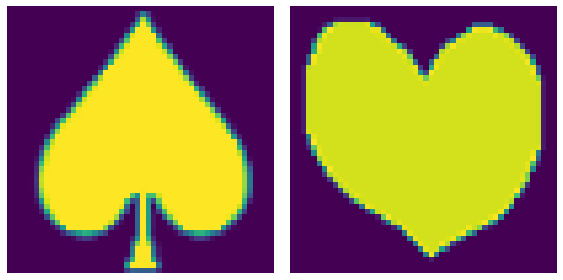

In [9]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
ims = [[np.loadtxt("spade"),np.loadtxt("heart")]]
ims = [[im/np.sum(im) for im in ims[0]]]
ax[0].imshow(ims[0][0])
ax[1].imshow(ims[0][1])
ax[0].axis("off")
ax[1].axis("off")
plt.tight_layout()
plt.show()

# Euclidean

In [10]:
#extract mm-spaces
metric_mode_input = "euclidean"
Xs = []
Ms = []
mus = []
for [l_im,r_im] in ims:
    assert np.shape(l_im) == np.shape(r_im)
    unit_length = np.linalg.norm(np.shape(l_im) - np.array([1,1])) #**2

    pos_1, mu_1 = img2atomic(torch.from_numpy(l_im))
    pos_1 = np.array(pos_1,dtype=float)
    pos_1 /= unit_length

    M_1 = ot.dist(pos_1,metric=metric_mode_input)
    M_1 = torch.from_numpy(M_1).double()

    pos_2, mu_2 = img2atomic(torch.from_numpy(r_im))
    pos_2 = np.array(pos_2,dtype=float)
    pos_2 /= unit_length
    M_2 = ot.dist(pos_2,metric=metric_mode_input)
    M_2 = torch.from_numpy(M_2).double()
    
    Xs.append([pos_1,pos_2])
    Ms.append([M_1,M_2])
    mus.append([mu_1,mu_2])

/Users/florian/opt/anaconda3/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
# Construct support of barycenters
Y_pixs = [12,25,40,50]
metric_modes = ["euclidean"]*len(Y_pixs)
Ys = []
M_Ys = []
M_Ys_sep = []
for Y_len,mode in zip(Y_pixs,metric_modes):
    Y = np.array(img2atomic(np.ones((Y_len,Y_len)))[0],dtype=float)
    Y /= np.linalg.norm([Y_len - 1,Y_len - 1])
    Y = torch.from_numpy(Y)
    M_Y = ot.dist(Y,Y,metric=mode)
    M_Y = M_Y.double()
    
    Ys.append(Y)
    M_Ys.append(M_Y)
    #in seperable form for sqeuclidean case
    if mode == "sqeuclidean":
        M_Y_sep = squareform(pdist(torch.linspace(0, 1/np.sqrt(2), Y_len)[:, None], metric='sqeuclidean'))
        M_Y_sep = torch.from_numpy(M_Y_sep)
    else:
        M_Y_sep = None
    M_Ys_sep.append(M_Y_sep)

Terminated after 502 iterations with last update 6.412618029265696e-07.


  0%|          | 0/502 [00:00<?, ?it/s]

Terminated after 138 iterations with last update 3.020263092553204e-06.


  0%|          | 0/138 [00:00<?, ?it/s]

Terminated after 49 iterations with last update 1.7230873602625484e-06.


  0%|          | 0/49 [00:00<?, ?it/s]

Terminated after 33 iterations with last update 5.9681994237885665e-05.


  0%|          | 0/33 [00:00<?, ?it/s]

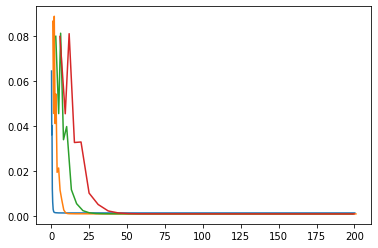

In [13]:
#UMGW
gw_losses_mm = []
times_mm = []
logs = []
final_margs = []
for [mu_1,mu_2],[M_1,M_2] in zip(mus,Ms):
    for M_Y,M_Y_sep,Y_pix in zip(M_Ys,M_Ys_sep,Y_pixs):
        
        #construct tree
        r = anytree.AnyNode(id=0)
        n1 = anytree.AnyNode(id=1,parent=r)
        n2 = anytree.AnyNode(id=2,parent=n1)
        forward = [node for node in anytree.PreOrderIter(r)]
        #left marg
        r.mu = mu_1.double()
        r.M = M_1
        r.rho = torch.Tensor([torch.inf])
        r.sep = None

        #barycenter
        n1.rho = torch.Tensor([0])
        n1.M = M_Y
        n1.len = len(M_Y)
        #n1.sep = None
        n1.sep = M_Y_sep

        #right marg
        n2.rho = torch.Tensor([torch.inf])
        n2.mu = mu_2.double()
        n2.M = M_2
        n2.sep = None
        
        r,log = umgw.UMGW_sep(r,eps= 0.00015,rho=None,plan_cvgce_thres=0,sink_cvgce_thres=1e-6,n_its_check_cvgce=10,n_its = 10000,log=True,max_time=200,epsmode="normal",random_state=0)
        logs.append(log)
        final_margs.append(n1.marginal.reshape((Y_pix,Y_pix)))
        #margs_mm = log[0]
        pis_mm = log["plans"]
        time_mm = log["times"]
        margs_mm = [torch.sum(pis_mm[i][0],dim=0) for i in range(len(pis_mm))]
        
        
        gw_loss_mm = []
        for i in trange(len(margs_mm)):
            P1,P2 = pis_mm[i]
            marg = margs_mm[i]

            constC, hC1, hC2 = ot.gromov.init_matrix(M_1.double(), M_Y.double(), mu_1, marg, "square_loss")
            l1 = ot.gromov.gwloss(constC, hC1, hC2, P1.double())

            constC, hC1, hC2 = ot.gromov.init_matrix(M_Y.double(),M_2.double(),marg,mu_2, "square_loss")
            l2 = ot.gromov.gwloss(constC, hC1, hC2, P2.double())
            gw_loss_mm.append(1/2 * float(l1+l2))
        gw_losses_mm.append(gw_loss_mm)
        times_mm.append(time_mm)
        
        plt.plot(time_mm,gw_loss_mm,label="UMGW '{0}'x'{1}'".format(len(M_Y),len(M_Y[0])) )
plt.show()

In [13]:
del pis_mm

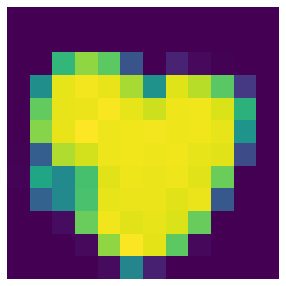

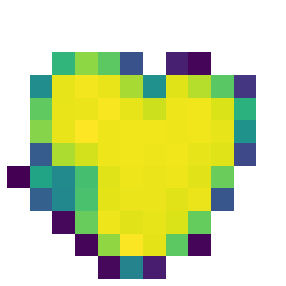

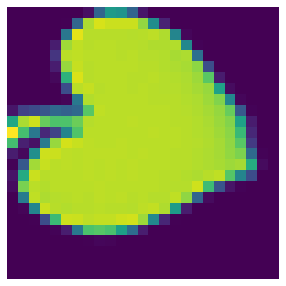

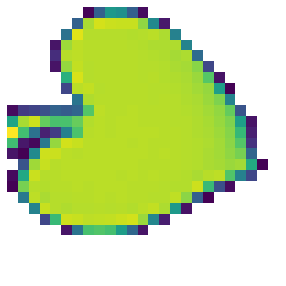

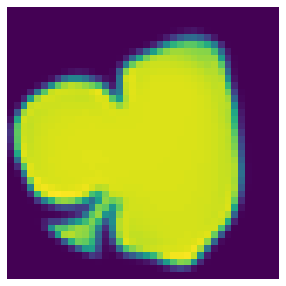

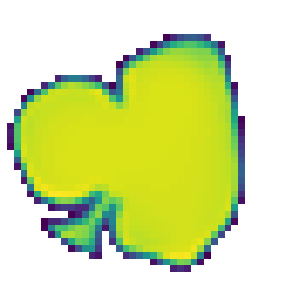

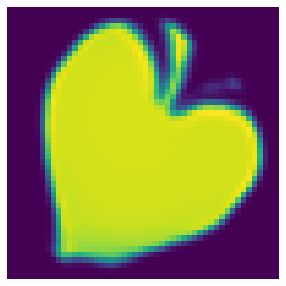

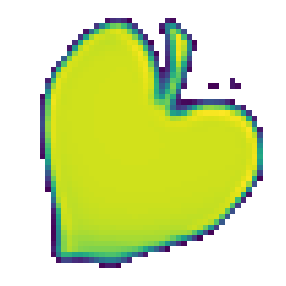

In [15]:
#single plots for paper:
n_supps = []
for i in range(len(final_margs)):
    #plt.imsave("umgw_eucl_spade_heart_im_{0}.png".format(i),final_margs[i])
    plt.figure(figsize=(5,5))
    
    plt.imshow(final_margs[i])
    plt.axis("off")
    #np.save("out/eucl/final_margs_{0}".format(i),final_margs[i])
    plt.figure(figsize=(5,5))
    mask = final_margs[i] < 1e-4   
    n_supps.append(torch.sum(mask != True))
    plt.imshow(np.ma.array(final_margs[i],mask=mask))    
    plt.axis("off")

In [15]:
#Number of "essential" support points
print(n_supps)

[tensor(81), tensor(348), tensor(901), tensor(1379)]


In [16]:
#BCD
M_1,M_2 = Ms[0]
mu_1,mu_2 = mus[0]
gw_losses_p_2d = []
gw_losses_p = []
times_p = []
embeddings = []
#n_samples = [20,50,100,200]
for n_sample in n_supps:
    height_p = ot.unif(n_sample)

    result_p = gromov_barycenters(n_sample,[M_1,M_2],[mu_1,mu_2],height_p,[0.5,0.5],"square_loss",tol=0,random_state = 0,max_time=200)

    Ms_p = result_p[0]
    Ts_p = result_p[1]
    time_p = result_p[2]

    gw_loss_p = []
    gw_loss_p_2d = []
    for i in trange(len(Ms_p)):
        T_p1,T_p2 = Ts_p[i]
        M_p = Ms_p[i]

        #gw loss
        constC, hC1, hC2 = ot.gromov.init_matrix(M_1.double(), M_p, mu_1, height_p, "square_loss")
        l1 = ot.gromov.gwloss(constC, hC1, hC2, T_p1.double())
        constC, hC1, hC2 = ot.gromov.init_matrix(M_2.double(),M_p,mu_2,height_p, "square_loss")
        l2 = ot.gromov.gwloss(constC, hC1, hC2, T_p2.double())
        gw_loss_p.append(1/2 * float(l1+l2))

        #embedd in 2d with MDS
        mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0)
        embedding = mds.fit_transform(M_p)#np.sqrt(M_p))
        
        M_p_2d = torch.from_numpy(ot.dist(embedding,metric="euclidean"))#**2
        
        #gw loss after embedding in 2d
        constC, hC1, hC2 = ot.gromov.init_matrix(M_1.double(), M_p_2d, mu_1, height_p, "square_loss")
        l1 = ot.gromov.gwloss(constC, hC1, hC2, T_p1.double())
        constC, hC1, hC2 = ot.gromov.init_matrix(M_2.double(),M_p_2d,mu_2,height_p, "square_loss")
        l2 = ot.gromov.gwloss(constC, hC1, hC2, T_p2.double())
        gw_loss_p_2d.append(1/2 * float(l1+l2))
    embeddings.append(embedding)
    gw_losses_p.append(gw_loss_p)
    gw_losses_p_2d.append(gw_loss_p_2d)
    times_p.append(time_p)

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 100000. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
/Users/florian/opt/anaconda3/lib/python3.8/site-packages/ot/lp/__init__.py:329: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


  0%|          | 0/4 [00:00<?, ?it/s]

In [17]:
del Ts_p
del Ms_p

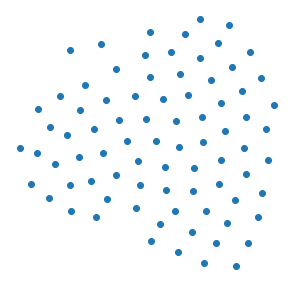

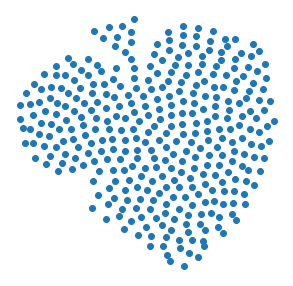

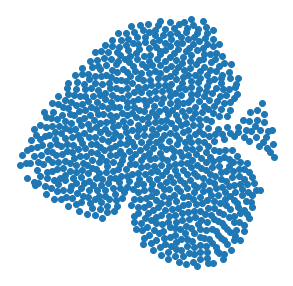

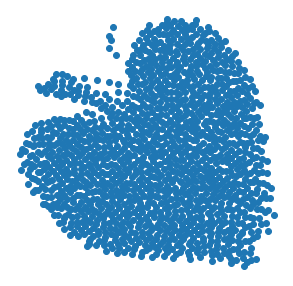

In [18]:
#single plots for paper
for i in range(len(embeddings)):
    plt.figure(figsize=(5,5))
    plt.scatter(embeddings[i][:,0],embeddings[i][:,1])
    plt.axis("off")
    #np.save("out/eucl/BCD_new_{0}".format(i),embeddings[i])

In [19]:
#EBCD, eps = 0.0005
M_1,M_2 = Ms[0]
mu_1,mu_2 = mus[0]
egw_losses_p_2d = []
egw_losses_p = []
etimes_p = []
eembeddings = []
#n_samples = [20,50,100,200]
for n_sample in n_supps:
    height_p = ot.unif(n_sample)

    result_p = entropic_gromov_barycenters(n_sample,[M_1,M_2],[mu_1,mu_2],height_p,[0.5,0.5],"square_loss",epsilon = 0.0005,tol=0,random_state = 0,max_time=200)

    Ms_p = result_p[0]
    Ts_p = result_p[1]
    time_p = result_p[2]

    gw_loss_p = []
    gw_loss_p_2d = []
    for i in trange(len(Ms_p)):
        T_p1,T_p2 = Ts_p[i]
        M_p = Ms_p[i]

        #gw loss
        constC, hC1, hC2 = ot.gromov.init_matrix(M_1.double(), M_p, mu_1, height_p, "square_loss")
        l1 = ot.gromov.gwloss(constC, hC1, hC2, T_p1.double())
        constC, hC1, hC2 = ot.gromov.init_matrix(M_2.double(),M_p,mu_2,height_p, "square_loss")
        l2 = ot.gromov.gwloss(constC, hC1, hC2, T_p2.double())
        gw_loss_p.append(1/2 * float(l1+l2))

        #embedd in 2d with MDS
        mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0)
        embedding = mds.fit_transform(M_p)#np.sqrt(M_p))
        
        M_p_2d = torch.from_numpy(ot.dist(embedding,metric="euclidean"))#**2
        
        #gw loss after embedding in 2d
        constC, hC1, hC2 = ot.gromov.init_matrix(M_1.double(), M_p_2d, mu_1, height_p, "square_loss")
        l1 = ot.gromov.gwloss(constC, hC1, hC2, T_p1.double())
        constC, hC1, hC2 = ot.gromov.init_matrix(M_2.double(),M_p_2d,mu_2,height_p, "square_loss")
        l2 = ot.gromov.gwloss(constC, hC1, hC2, T_p2.double())
        gw_loss_p_2d.append(1/2 * float(l1+l2))
    eembeddings.append(embedding)
    egw_losses_p.append(gw_loss_p)
    egw_losses_p_2d.append(gw_loss_p_2d)
    etimes_p.append(time_p)

/Users/florian/opt/anaconda3/lib/python3.8/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


  0%|          | 0/97 [00:00<?, ?it/s]

/Users/florian/opt/anaconda3/lib/python3.8/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/Users/florian/opt/anaconda3/lib/python3.8/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 13
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


  0%|          | 0/32 [00:00<?, ?it/s]

/Users/florian/opt/anaconda3/lib/python3.8/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


  0%|          | 0/8 [00:00<?, ?it/s]

/Users/florian/opt/anaconda3/lib/python3.8/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


  0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
del Ts_p
del Ms_p

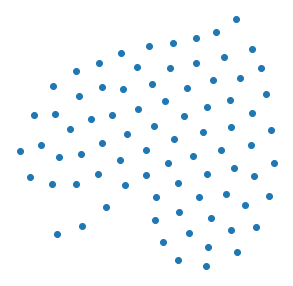

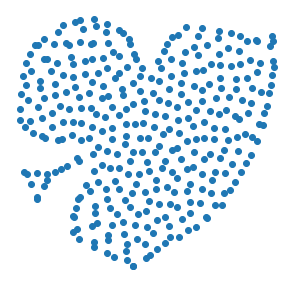

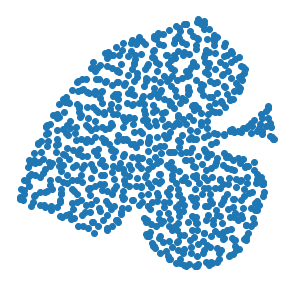

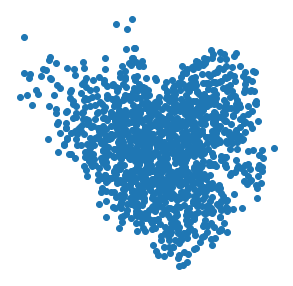

In [21]:
#single plots for paper
for i in range(len(eembeddings)):
    plt.figure(figsize=(5,5))
    plt.scatter(eembeddings[i][:,0],eembeddings[i][:,1])
    plt.axis("off")
    #np.save("out/eucl/EBCD_5e-4_new_{0}".format(i),eembeddings[i])

In [22]:
#EBCD, 0.005
M_1,M_2 = Ms[0]
mu_1,mu_2 = mus[0]
e2gw_losses_p_2d = []
e2gw_losses_p = []
e2times_p = []
e2embeddings = []
for n_sample in n_supps:
    height_p = ot.unif(n_sample)

    result_p = entropic_gromov_barycenters(n_sample,[M_1,M_2],[mu_1,mu_2],height_p,[0.5,0.5],"square_loss",epsilon =0.005,tol=0,random_state = 0,max_time=200)

    Ms_p = result_p[0]
    Ts_p = result_p[1]
    time_p = result_p[2]

    gw_loss_p = []
    gw_loss_p_2d = []
    for i in trange(len(Ms_p)):
        T_p1,T_p2 = Ts_p[i]
        M_p = Ms_p[i]

        #gw loss
        constC, hC1, hC2 = ot.gromov.init_matrix(M_1.double(), M_p, mu_1, height_p, "square_loss")
        l1 = ot.gromov.gwloss(constC, hC1, hC2, T_p1.double())
        constC, hC1, hC2 = ot.gromov.init_matrix(M_2.double(),M_p,mu_2,height_p, "square_loss")
        l2 = ot.gromov.gwloss(constC, hC1, hC2, T_p2.double())
        gw_loss_p.append(1/2 * float(l1+l2))

        #embedd in 2d with MDS
        mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0)
        embedding = mds.fit_transform(M_p)#np.sqrt(M_p))
        
        M_p_2d = torch.from_numpy(ot.dist(embedding,metric="euclidean"))#**2
        
        #gw loss after embedding in 2d
        constC, hC1, hC2 = ot.gromov.init_matrix(M_1.double(), M_p_2d, mu_1, height_p, "square_loss")
        l1 = ot.gromov.gwloss(constC, hC1, hC2, T_p1.double())
        constC, hC1, hC2 = ot.gromov.init_matrix(M_2.double(),M_p_2d,mu_2,height_p, "square_loss")
        l2 = ot.gromov.gwloss(constC, hC1, hC2, T_p2.double())
        gw_loss_p_2d.append(1/2 * float(l1+l2))
    e2embeddings.append(embedding)
    e2gw_losses_p.append(gw_loss_p)
    e2gw_losses_p_2d.append(gw_loss_p_2d)
    e2times_p.append(time_p)

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [23]:
del Ts_p
del Ms_p

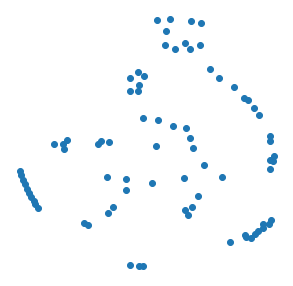

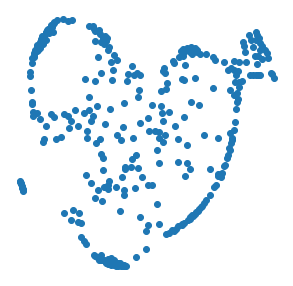

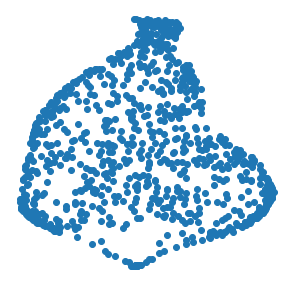

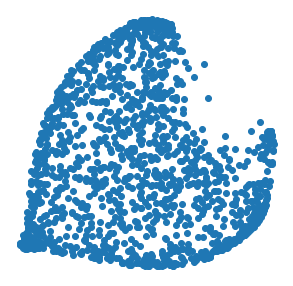

In [24]:
#single plots for paper
for i in range(len(e2embeddings)):
    plt.figure(figsize=(5,5))
    plt.scatter(e2embeddings[i][:,0],e2embeddings[i][:,1])
    plt.axis("off")
    #np.save("out/eucl/EBCD_5e-3_new_{0}".format(i),e2embeddings[i])

In [25]:
#save result
#for i in range(4):
#    np.save("out/eucl/times_p_{0}".format(i),times_p[i])
#    np.save("out/eucl/etimes_p_{0}".format(i),etimes_p[i])
#    np.save("out/eucl/e2times_p_{0}".format(i),e2times_p[i])
#    np.save("out/eucl/times_mm_{0}".format(i),times_mm[i])
#    
#    np.save("out/eucl/gw_losses_p_{0}".format(i),gw_losses_p[i])
#    np.save("out/eucl/egw_losses_p_{0}".format(i),egw_losses_p[i])
#    np.save("out/eucl/e2gw_losses_p_{0}".format(i),e2gw_losses_p[i])
#    np.save("out/eucl/gw_losses_mm_{0}".format(i),gw_losses_mm[i])

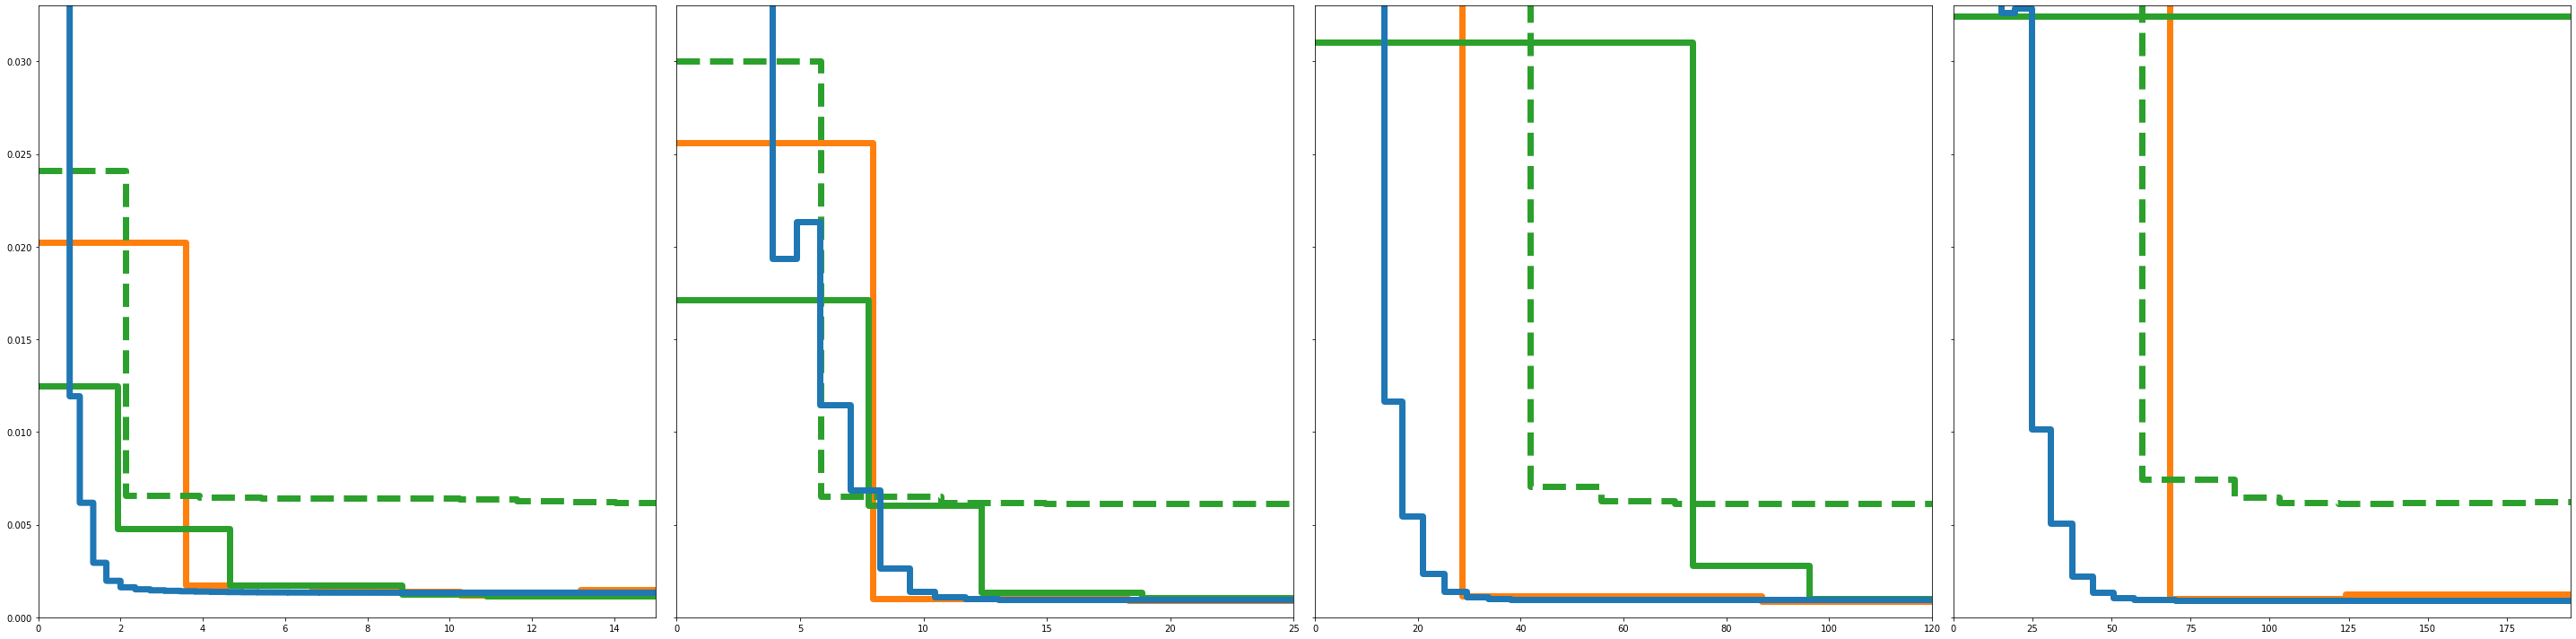

In [40]:
#plot runtime comparison
xlims = [(0,15),(0,25),(0,120),(0,195)]
colors = sns.color_palette()
where = "post"

fig,ax = plt.subplots(1,4,sharey=True,figsize=(40,10))
linewidth = 7
ax[0].set_ylim(0.0,0.033)
for i in range(4):
    ax[i].set_xlim(xlims[i])
    ax[i].step(times_p[i],gw_losses_p[i],label="BCD".format(n_supps[i]),color=colors[1],linewidth = linewidth,where=where)
    ax[i].step(etimes_p[i],egw_losses_p[i],label="EBCD, eps = {0}".format(0.0005),color=colors[2],linewidth = linewidth,where=where)
    ax[i].step(e2times_p[i],e2gw_losses_p[i],label="EBCD, eps = {0}".format(0.005),color=colors[2],linestyle="dashed",linewidth = linewidth,where=where)
    ax[i].step(times_mm[i],gw_losses_mm[i],label="UMGW {0}x{1}".format(Y_pixs[i],Y_pixs[i]),color=colors[0],linewidth = linewidth,where=where)
    
plt.tight_layout()
plt.show()